# Config

In [ ]:
MODEL_NAME = "HooshvareLab/bert-base-parsbert-uncased"
NUM_LABELS = 3

SAFE_MAX_SEQ_LEN = 160

INSTALL_HAZM_LIB = False


In [ ]:
EPOCHS = 5
LEARNING_RATE = 1e-5
BATCH_SIZE = 16


# Get requirements

In [ ]:
import os

if INSTALL_HAZM_LIB:
  !pip install sentencepiece python-multipart uvicorn kaleido fastapi hazm -q
  os.kill(os.getpid(), 9)

!pip install transformers==4.35.2 datasets==2.16.1 numpy==1.23.5 -q

if not os.path.exists("./FarsTail"):
  !git clone https://github.com/dml-qom/FarsTail.git
if os.path.exists("./FarsTail/data"):
  !mv FarsTail/data data

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.12.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have dis

# Examine Dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm

import gc

In [ ]:
train_data = pd.read_csv('data/Train-word.csv', sep='\t')
val_data = pd.read_csv('data/Val-word.csv', sep='\t')
test_data = pd.read_csv('data/Test-word.csv', sep='\t')

print(f"#Train      samples:   {len(train_data)}")
print(f"#Validation samples:   {len(val_data)}")
print(f"#Test       samples:   {len(test_data)}")

#Train      samples:   7266
#Validation samples:   1537
#Test       samples:   1564


In [ ]:
train_data.head(5)

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [ ]:
val_data.head(5)

,premise,hypothesis,label
0,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,کتاب مگیستی (المجسطی) از آثار بطلمیوس است و از...,e
1,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,المجسطی (مگیستی)، یکی از کتاب های هرون از مکتب...,c
2,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,ترجمه المجسطی، پایه تهیه جداول نجومی گردید که ...,n
3,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,کتاب کلمات قصار یا فصول، اثر بقراط است.,e
4,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,جالینوس، نویسنده کتاب کلمات قصار بوده است.,c


In [ ]:
test_data.head(5)

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0


# Preprocess

## Visual Exploration

label
n    2448
e    2429
c    2389
Name: count, dtype: int64


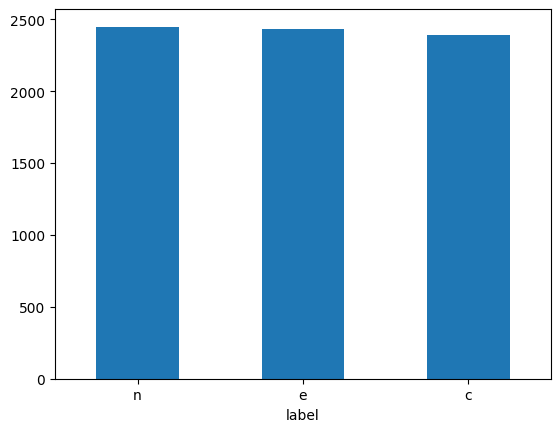

In [ ]:
tld = train_data['label'].value_counts().sort_values(ascending=False)
print(tld)
tld.plot.bar()
plt.xticks(rotation=0)
plt.show()

In [ ]:
def add_percent_to_bars(ax):
  for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()
    percent = height * 100
    percent_str = f"{percent:.1f}%"
    plt.text(x + width / 2, y + height / 2, percent_str,
             horizontalalignment="center",
             verticalalignment="center")

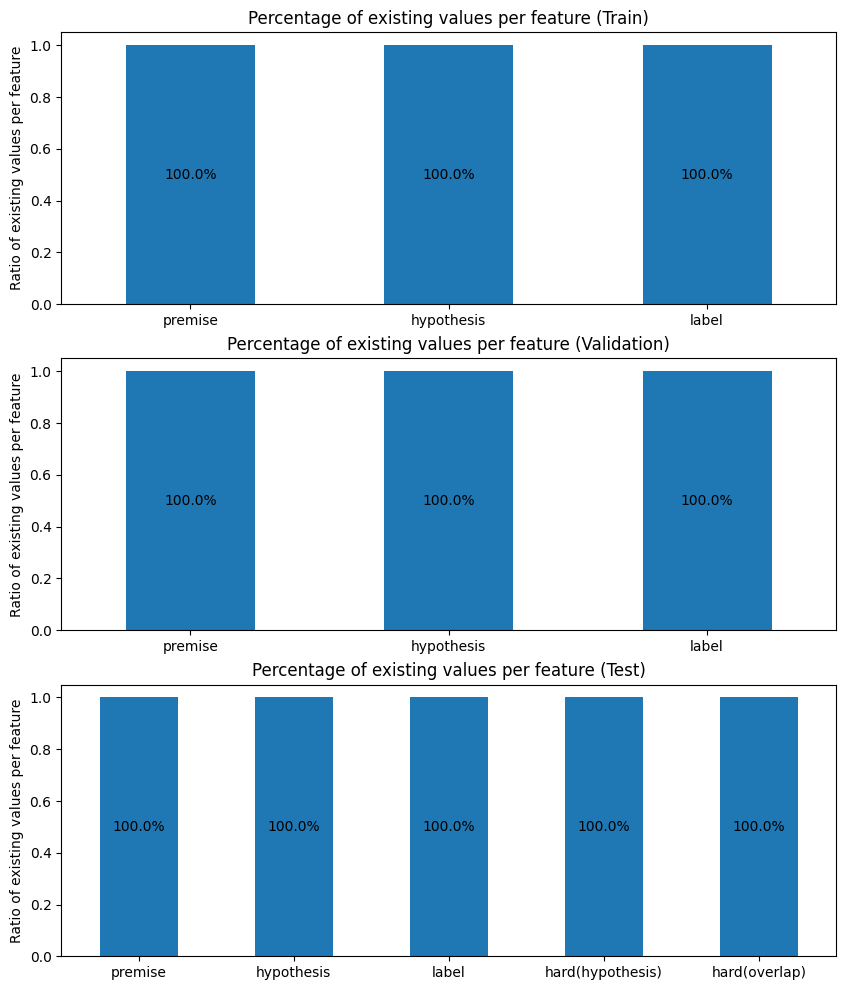

In [ ]:
plt.subplot(3, 1, 1)
ax = train_data.notna().mean().sort_values().plot(
    kind="bar", figsize=(10, 12),
    title="Percentage of existing values per feature (Train)",
    ylabel="Ratio of existing values per feature",)
plt.xticks(rotation=0)
plt.ylim(bottom=0.000)
add_percent_to_bars(ax)

plt.subplot(3, 1, 2)
ax = val_data.notna().mean().sort_values().plot(
    kind="bar", figsize=(10, 12),
    title="Percentage of existing values per feature (Validation)",
    ylabel="Ratio of existing values per feature")
plt.xticks(rotation=0)
plt.ylim(bottom=0.000)
add_percent_to_bars(ax)

plt.subplot(3, 1, 3)
ax = test_data.notna().mean().sort_values().plot(
    kind="bar", figsize=(10, 12),
    title="Percentage of existing values per feature (Test)",
    ylabel="Ratio of existing values per feature")
plt.xticks(rotation=0)
plt.ylim(bottom=0.000)
add_percent_to_bars(ax)

plt.show()

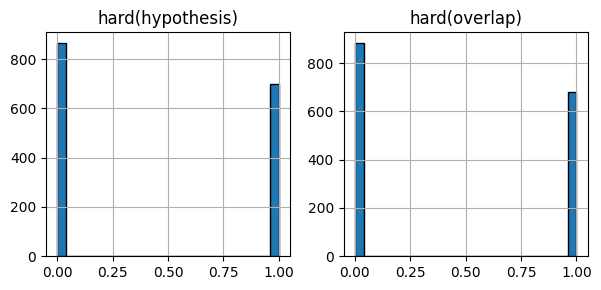

In [ ]:
test_data.hist(bins=25, figsize=(15, 3), layout=(-1, 5), edgecolor="black")
plt.tight_layout()
plt.show()

## Encode label column's values

In [ ]:
def transform_column(df, transform, col):
  df[col] = df[col].replace(transform)

In [ ]:
label_transforms = {'e': 0, 'n': 1, 'c': 2}

In [ ]:
transform_column(train_data, label_transforms, 'label')
transform_column(val_data,   label_transforms, 'label')
transform_column(test_data,  label_transforms, 'label')

## Normalize texts

It is recommended to use hazm's normalizer to normalize text, but it is not neccessary for transformers and for PartBERT model. So, we will continiuoue without using this.

In [ ]:
# import hazm
# normalizer = hazm.Normalizer()

## Sequence Length (by tokens)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

In [ ]:
def plot_tokenized_lengths(df, tokenizer):
  premise_lengths, hypothesis_lengths, sample_lengths = [], [], []
  itr = tqdm(df.iterrows(), leave=False, total=len(df))

  for index, row in itr:
    tv = tokenizer(row["premise"])
    premise_lengths.append(len(tv['input_ids']))

    tv = tokenizer(row["hypothesis"])
    hypothesis_lengths.append(len(tv['input_ids']))

    tv = tokenizer(row["premise"], row["hypothesis"])
    sample_lengths.append(len(tv['input_ids']))

  lengths = {'premise': premise_lengths, 'hypothesis': hypothesis_lengths, 'premise+hypo(sample-wise)': sample_lengths}
  columns = list(lengths.keys())
  lengths_df = pd.DataFrame(lengths)
  lengths_df.plot(kind='box', figsize=(10, 6))
  plt.xticks(ticks=range(1, len(columns)+1), labels=columns)
  plt.title('Lengths of tokenized samples')
  plt.xlabel('Column name')
  plt.ylabel('Length')
  plt.show()

  template = "| {:<25} | {:<8} | {:<8} | {:<8}|"
  print(f"--{'-'*25}---{'-'*8}---{'-'*8}---{'-'*8}-")
  print(template.format("Group cat", "Min", "Mean", "Max"))
  print(f"|-{'-'*25} + {'-'*8} + {'-'*8} + {'-'*8}|")
  for col in columns:
    print(template.format(col, round(np.min(lengths[col]),1), round(np.mean(lengths[col]),1), round(np.max(lengths[col]),1)))
  print(f"--{'-'*25}---{'-'*8}---{'-'*8}---{'-'*8}-")


### Train dataset

  0%|          | 0/7266 [00:00<?, ?it/s]

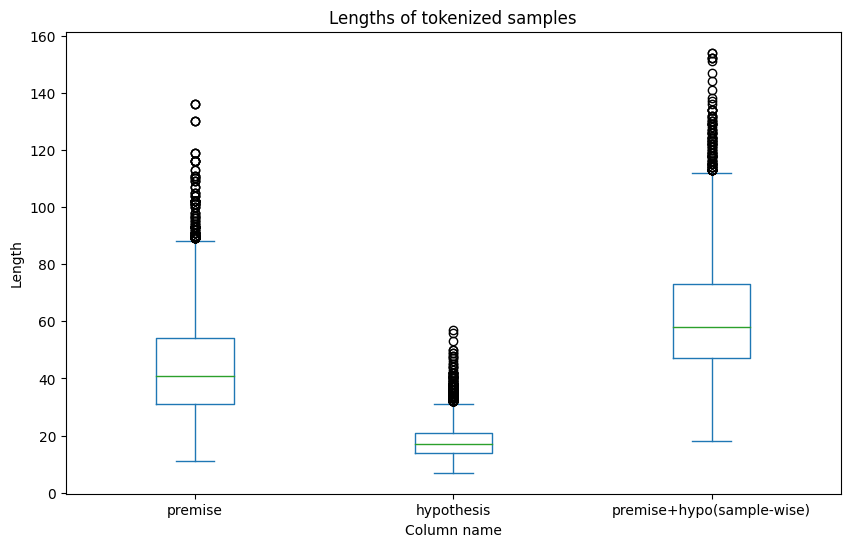

-------------------------------------------------------------
| Group cat                 | Min      | Mean     | Max     |
|-------------------------- + -------- + -------- + --------|
| premise                   | 11       | 43.8     | 136     |
| hypothesis                | 7        | 18.1     | 57      |
| premise+hypo(sample-wise) | 18       | 60.9     | 154     |
-------------------------------------------------------------


In [ ]:
plot_tokenized_lengths(train_data, tokenizer)

### Validation Dataset

  0%|          | 0/1537 [00:00<?, ?it/s]

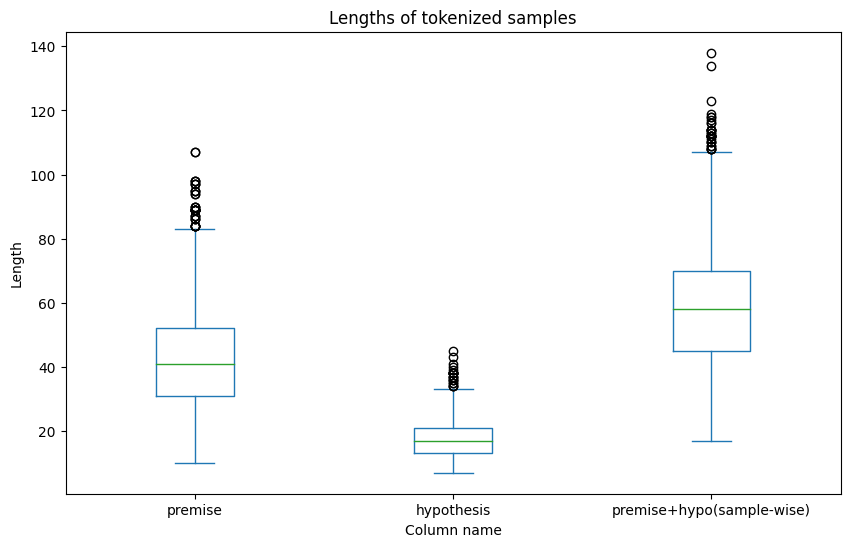

-------------------------------------------------------------
| Group cat                 | Min      | Mean     | Max     |
|-------------------------- + -------- + -------- + --------|
| premise                   | 10       | 43.2     | 107     |
| hypothesis                | 7        | 17.5     | 45      |
| premise+hypo(sample-wise) | 17       | 59.7     | 138     |
-------------------------------------------------------------


In [ ]:
plot_tokenized_lengths(val_data, tokenizer)

### Test Dataset

  0%|          | 0/7266 [00:00<?, ?it/s]

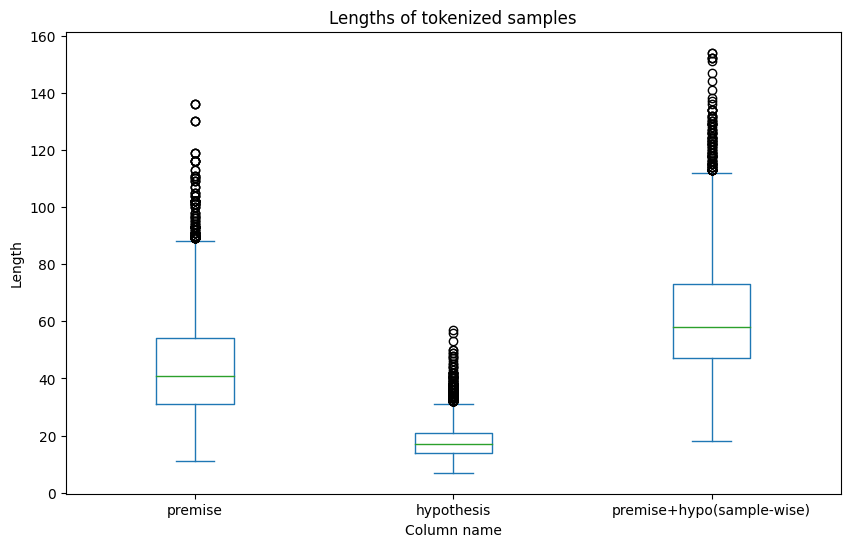

-------------------------------------------------------------
| Group cat                 | Min      | Mean     | Max     |
|-------------------------- + -------- + -------- + --------|
| premise                   | 11       | 43.8     | 136     |
| hypothesis                | 7        | 18.1     | 57      |
| premise+hypo(sample-wise) | 18       | 60.9     | 154     |
-------------------------------------------------------------


In [ ]:
plot_tokenized_lengths(train_data, tokenizer)

In [ ]:
del tokenizer

## Tokenize datasets

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(val_data)
test_dataset  = Dataset.from_pandas(test_data)

In [ ]:
tokenize_func = lambda x: tokenizer(x['premise'], x['hypothesis'], truncation=True, padding='max_length', max_length=SAFE_MAX_SEQ_LEN)
remove_cols = ['premise', 'hypothesis']
rename_cols = ('label', 'labels')

train_tokenized = train_dataset.map(
    tokenize_func,
    batched=True,
)
train_tokenized = train_tokenized.remove_columns(remove_cols).rename_column(*rename_cols).with_format('pt')

valid_tokenized = valid_dataset.map(
    tokenize_func,
    batched=True,
)
valid_tokenized = valid_tokenized.remove_columns(remove_cols).rename_column(*rename_cols).with_format('pt')

test_tokenized  = test_dataset.map(
    tokenize_func,
    batched=True,
)
test_tokenized = test_tokenized.remove_columns(remove_cols+['hard(hypothesis)', 'hard(overlap)']).rename_column(*rename_cols).with_format('pt')

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

In [ ]:
del tokenizer, train_data, val_data, test_data
gc.collect()

40

# Tuning Utils

In [ ]:
import torch
import sklearn.metrics as metrics
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
@torch.no_grad()
def model_eval(model, loader):
  """Returns test_loss, test_acc"""
  test_loss = 0.0
  test_acc = 0.0
  total_samples = 0

  model.eval()
  itr = tqdm(loader, total=len(loader), leave=False)

  for batch in itr:
      total_samples += len(batch['input_ids'])

      batch = move_dataset_sample_to(batch)

      output = model(**batch)

      loss = output[0]
      logits = output[1]


      test_loss += loss.item()

      _, preds = torch.max(logits, 1)
      test_correct = torch.sum(preds == batch['labels']).item()
      test_acc += test_correct

      itr.set_description("(Eval)")
      itr.set_postfix(
          loss=round(test_loss/total_samples, 5),
          accuracy=round(test_acc/total_samples, 5),
      )

  test_loss = test_loss / len(loader)
  test_acc = test_acc / total_samples

  return test_loss, test_acc


In [ ]:
def move_dataset_sample_to(sample):
  if isinstance(sample, dict):
    for col in sample.keys():
      sample[col] = sample[col].to(DEVICE)
  else:
    for i in range(len(sample)):
      for col in sample[i].keys():
        sample[i][col] = sample[i][col].to(DEVICE)
  return sample

In [ ]:
def train_model(
        model,
        batch_size,
        epochs,
        train_set,
        valid_set,
        test_set,
        lr=2e-5,
):

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  test_losses = []
  test_accs = []

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98)

  itr = tqdm(train_loader, total=len(train_loader), leave=False)

  for epoch in range(epochs):
      model.train()
      epoch_loss = 0
      epoch_acc = 0
      epoch_samples = 0
      for idx, (batch) in enumerate(itr, start=1):
          epoch_samples += len(batch['input_ids'])
          model.zero_grad()
          optimizer.zero_grad()

          batch = move_dataset_sample_to(batch)

          output = model(**batch)

          loss = output[0]
          logits = output[1]

          epoch_loss += loss.item()

          loss.backward()

          optimizer.step()
#           scheduler.step()

          _, preds = torch.max(logits, 1)
          correct = torch.sum(preds == batch['labels']).item()
          epoch_acc += correct

          itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
          itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(epoch_acc/epoch_samples, 5),
          )

      epoch_loss = epoch_loss / len(train_loader)

      train_losses.append(epoch_loss)
      train_accs.append(epoch_acc/epoch_samples)

      model.eval()
      valid_loss, valid_acc = model_eval(
          model=model,
          loader=valid_loader
      )
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)

      test_loss, test_acc = model_eval(
          model=model,
          loader=test_loader,
      )
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  history = {
    "train_loss": train_losses,
    "train_acc": train_accs,

    "valid_loss": valid_losses,
    "valid_acc": valid_accs,

    "test_loss": test_losses,
    "test_acc": test_accs,
  }
  return history

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [ ]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset):

  loader = DataLoader(dataset, batch_size=32, shuffle=False)
  probabilities = []
  labels = []

  for batch in tqdm(loader, leave=False, desc="Generate data"):
      batch = move_dataset_sample_to(batch)

      prob = model(**batch)[1]

      probabilities.append(prob.detach())
      labels.append(batch['labels'].detach())

  probabilities = torch.cat(probabilities, dim=0)
  _, predicted = torch.max(probabilities.detach(), dim=1)
  labels = torch.cat(labels, dim=0).detach().cpu().squeeze().numpy()
  predicted = predicted.detach().cpu().squeeze().numpy()

  cm = metrics.confusion_matrix(
      y_true=labels,
      y_pred=predicted,
  )

  plt.figure(figsize=(10,10))
  sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
  plt.xlabel('Predicted Label', labelpad=20)
  plt.ylabel('True Label', labelpad=20)
  plt.title('Confusion Matrix', fontsize=30)

  recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
  f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
  precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
  report = metrics.classification_report(y_true=labels, y_pred=predicted)

  return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


In [ ]:
def count_parameters(model: torch.nn.Module):
  num_params = sum(p.numel() for _, p in model.named_parameters())
  return num_params

def count_learnable_parameters(model: torch.nn.Module):
  num_params = sum(p.numel() for _, p in model.named_parameters() if p.requires_grad)
  return num_params

def report_learnable_param(model: torch.nn.Module):
  all_param = count_parameters(model)
  l_param   = count_learnable_parameters(model)

  print(f"All       Parameters: {all_param:<10}")
  print(f"Learnable Parameters: {l_param:<10} ({100*l_param/all_param:.2f}%)")
  print(f"Frozen    Parameters: {all_param-l_param:<10} ({100-100*l_param/all_param:.2f}%)")

# Ordinary Fine Tuning

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# train_tokenized = train_tokenized.map(move_dataset_sample_to, batched=True)
# valid_tokenized = valid_tokenized.map(move_dataset_sample_to, batched=True)
# test_tokenized = test_tokenized.map(move_dataset_sample_to, batched=True)

In [ ]:
report_learnable_param(model)

All       Parameters: 162843651 
Learnable Parameters: 162843651  (100.00%)
Frozen    Parameters: 0          (0.00%)


In [ ]:
nft_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    train_set=train_tokenized,
    valid_set=valid_tokenized,
    test_set=test_tokenized,
    lr=LEARNING_RATE,
)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

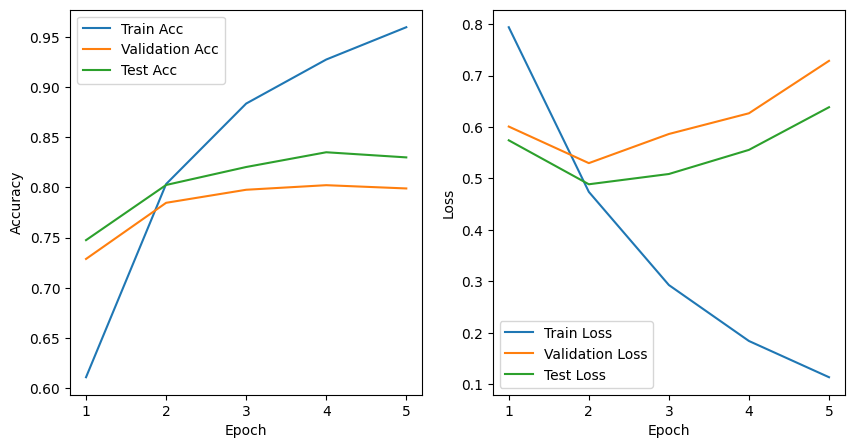

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", nft_history["train_acc"]),
            ("Validation Acc", nft_history["valid_acc"]),
            ("Test Acc", nft_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", nft_history["train_loss"]),
            ("Validation Loss", nft_history["valid_loss"]),
            ("Test Loss", nft_history["test_loss"]),
        ]
    }
)


Generate data:   0%|          | 0/49 [00:00<?, ?it/s]

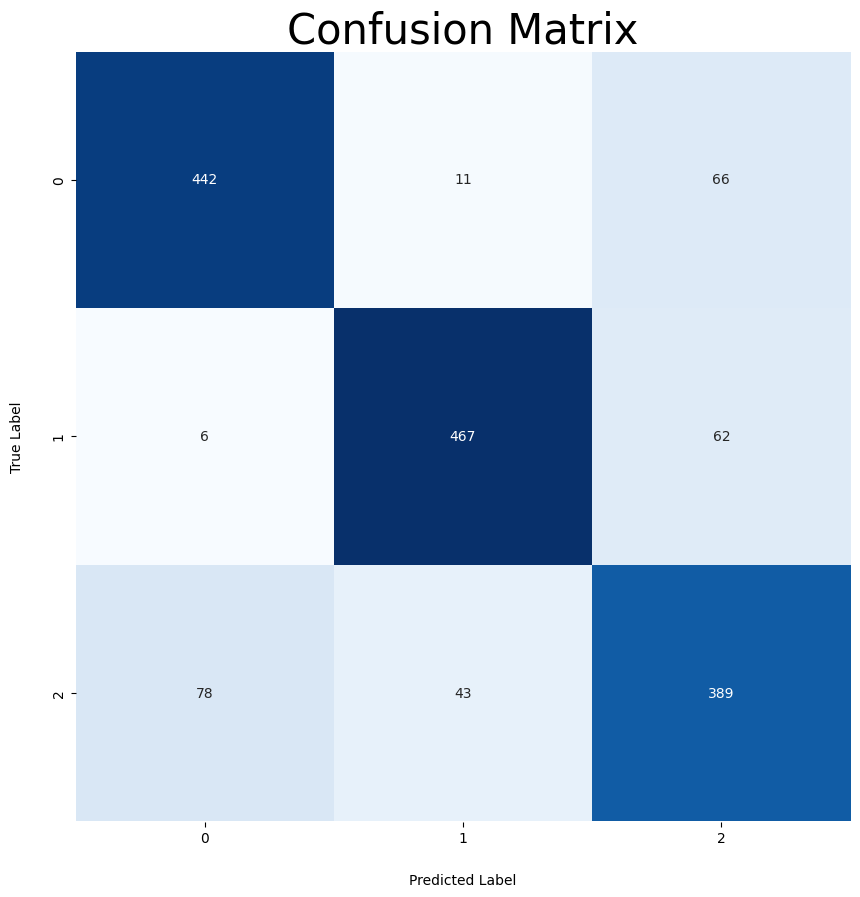

In [ ]:
nft_cls_report = generate_confusion_matrix(
    model=model,
    dataset=test_tokenized,
)

In [ ]:
print(f"Recall:    {nft_cls_report['recall']:.3f}")
print(f"F1:        {nft_cls_report['f1']:.3f}")
print(f"Precision: {nft_cls_report['precision']:.3f}")
print(nft_cls_report['report'])

Recall:    0.829
F1:        0.829
Precision: 0.830
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       519
           1       0.90      0.87      0.88       535
           2       0.75      0.76      0.76       510

    accuracy                           0.83      1564
   macro avg       0.83      0.83      0.83      1564
weighted avg       0.83      0.83      0.83      1564



In [ ]:
del model

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

10795

# Fine-Tune with some layers frozen

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

In [ ]:
def freeze_model_layer_wise(model: torch.nn.Module, include: list=None, exclude: list=None, log=False):
  if include is None:
    include = []
  if exclude is None:
    exclude = []

  for p_name, param in model.named_parameters():
    if any(i in p_name for i in include) and not any(e in p_name for e in exclude):
      param.requires_grad = False
      if log:
        print(f"[-] {p_name:<60}  Disable")
    else:
      param.requires_grad = True
      if log:
        print(f"[+] {p_name:<60}  Enable")
  model.gradient_checkpointing_enable()
  model.enable_input_require_grads()

def report_param_status(model: torch.nn.Module):
  for p_name, param in model.named_parameters():
    print(f"[{'+' if param.requires_grad else '-'}] {p_name}")


## Print Model's layer names

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
for p_name, _ in model.named_parameters():
    print(p_name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [ ]:
del model

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

16

## Fine-Tune with bottom 9 layers frozen

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
freeze_model_layer_wise(
    model=model,
    include=[
        "layer.0.",
        "layer.1.",
        "layer.2.",
        "layer.3.",
        "layer.4.",
        "layer.5.",
        "layer.6.",
        "layer.7.",
        "layer.8.",
    ],
)

In [ ]:
report_learnable_param(model)

All       Parameters: 162843651 
Learnable Parameters: 99052803   (60.83%)
Frozen    Parameters: 63790848   (39.17%)


In [ ]:
ft_9lf_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    train_set=train_tokenized,
    valid_set=valid_tokenized,
    test_set=test_tokenized,
    lr=LEARNING_RATE,
)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

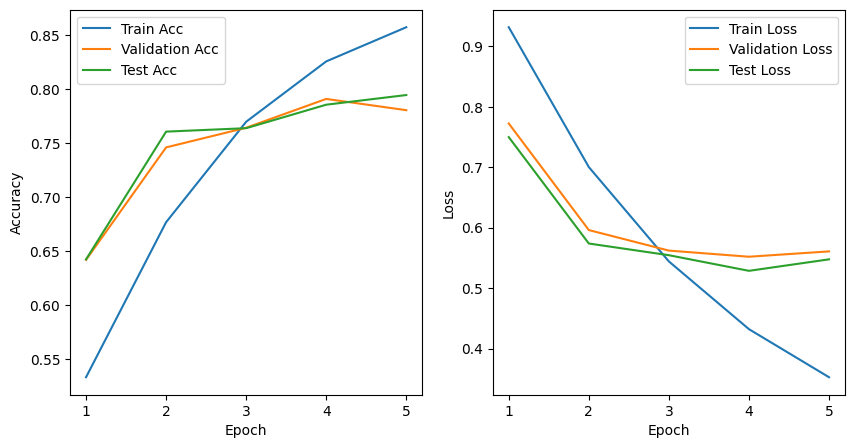

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", ft_9lf_history["train_acc"]),
            ("Validation Acc", ft_9lf_history["valid_acc"]),
            ("Test Acc", ft_9lf_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", ft_9lf_history["train_loss"]),
            ("Validation Loss", ft_9lf_history["valid_loss"]),
            ("Test Loss", ft_9lf_history["test_loss"]),
        ]
    }
)


Generate data:   0%|          | 0/49 [00:00<?, ?it/s]

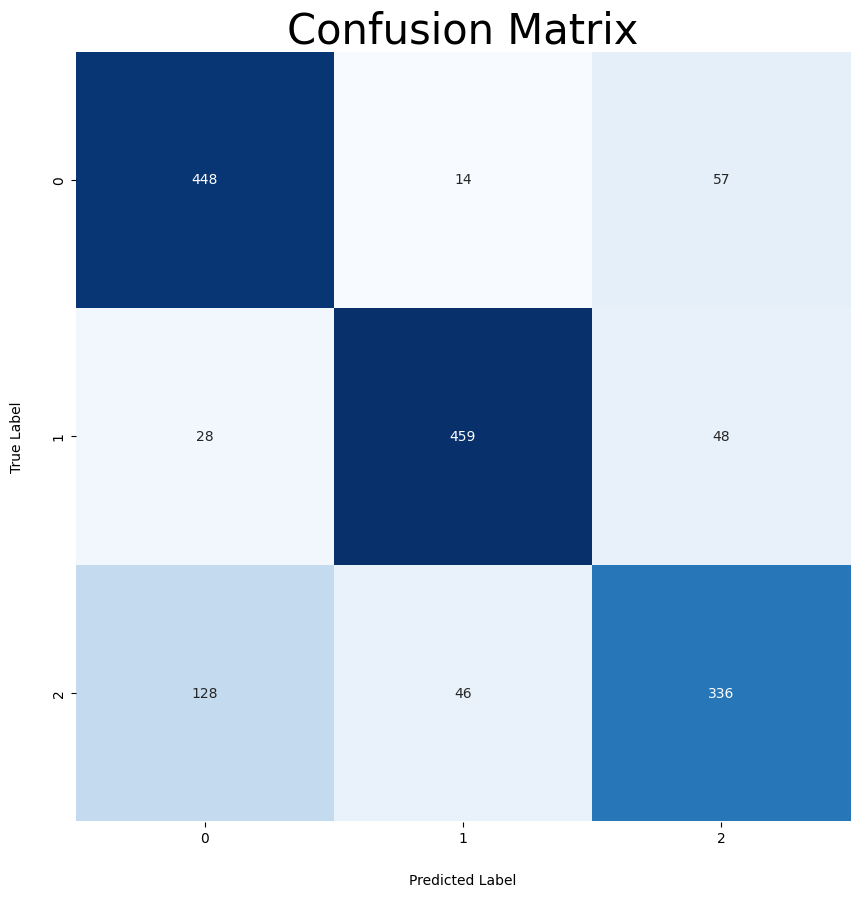

In [ ]:
ft_9lf_report = generate_confusion_matrix(
    model=model,
    dataset=test_tokenized,
)

In [ ]:
print(f"Recall:    {ft_9lf_report['recall']:.3f}")
print(f"F1:        {ft_9lf_report['f1']:.3f}")
print(f"Precision: {ft_9lf_report['precision']:.3f}")
print(ft_9lf_report['report'])

Recall:    0.793
F1:        0.792
Precision: 0.796
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       519
           1       0.88      0.86      0.87       535
           2       0.76      0.66      0.71       510

    accuracy                           0.79      1564
   macro avg       0.80      0.79      0.79      1564
weighted avg       0.80      0.79      0.79      1564



In [ ]:
del model

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

10474

## Fine-Tune with all layers frozen except 'embedding' and the last layer

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
freeze_model_layer_wise(
    model=model,
    include=[
        "layer.0.",
        "layer.1.",
        "layer.2.",
        "layer.3.",
        "layer.4.",
        "layer.5.",
        "layer.6.",
        "layer.7.",
        "layer.8.",
        "layer.9.",
        "layer.10.",
    ],
    exclude=[
        "embeddings.",
        "layer.11.",
        "pooler.",
        "classifier.",
    ],
)

In [ ]:
report_learnable_param(model)

All       Parameters: 162843651 
Learnable Parameters: 84877059   (52.12%)
Frozen    Parameters: 77966592   (47.88%)


In [ ]:
ft_11lf_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    train_set=train_tokenized,
    valid_set=valid_tokenized,
    test_set=test_tokenized,
    lr=LEARNING_RATE,
)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

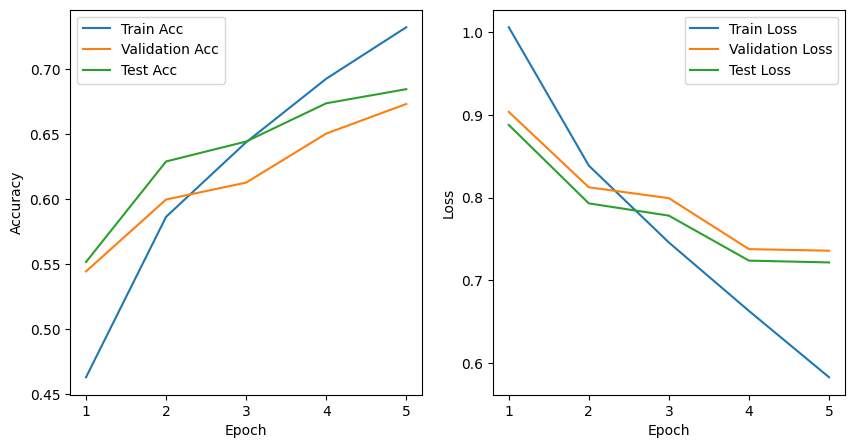

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", ft_11lf_history["train_acc"]),
            ("Validation Acc", ft_11lf_history["valid_acc"]),
            ("Test Acc", ft_11lf_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", ft_11lf_history["train_loss"]),
            ("Validation Loss", ft_11lf_history["valid_loss"]),
            ("Test Loss", ft_11lf_history["test_loss"]),
        ]
    }
)

Generate data:   0%|          | 0/49 [00:00<?, ?it/s]

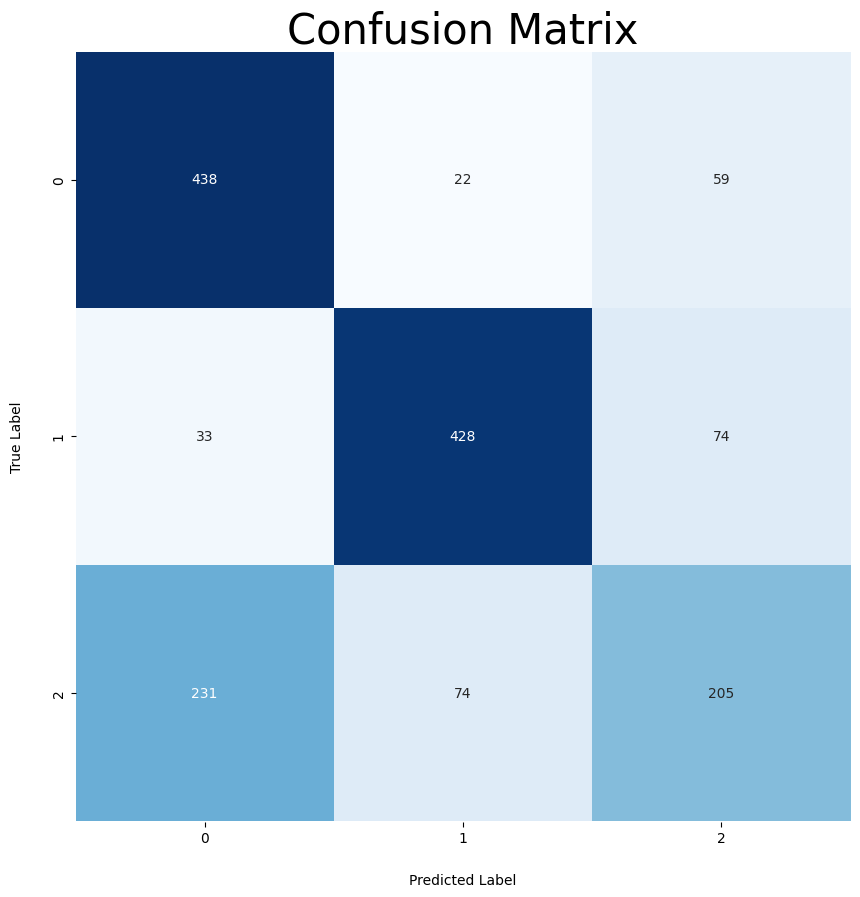

In [ ]:
ft_11lf_report = generate_confusion_matrix(
    model=model,
    dataset=test_tokenized,
)

In [ ]:
print(f"Recall:    {ft_11lf_report['recall']:.3f}")
print(f"F1:        {ft_11lf_report['f1']:.3f}")
print(f"Precision: {ft_11lf_report['precision']:.3f}")
print(ft_11lf_report['report'])

Recall:    0.682
F1:        0.670
Precision: 0.682
              precision    recall  f1-score   support

           0       0.62      0.84      0.72       519
           1       0.82      0.80      0.81       535
           2       0.61      0.40      0.48       510

    accuracy                           0.68      1564
   macro avg       0.68      0.68      0.67      1564
weighted avg       0.68      0.68      0.67      1564



In [ ]:
del model

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

10255

# Fine-Tune with only first 9-layers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import copy

In [ ]:
def deleteEncodingLayers(model, keep_till_layer_number):
    oldModuleList = model.bert.encoder.layer
    newModuleList = torch.nn.ModuleList()

    for i in range(0, keep_till_layer_number):
        newModuleList.append(oldModuleList[i])

    copyOfModel = copy.deepcopy(model)
    copyOfModel.bert.encoder.layer = newModuleList

    return copyOfModel

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = deleteEncodingLayers(model=model, keep_till_layer_number=9)

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
report_learnable_param(model)

All       Parameters: 141580035 
Learnable Parameters: 141580035  (100.00%)
Frozen    Parameters: 0          (0.00%)


In [ ]:
report_param_status(model)

[+] bert.embeddings.word_embeddings.weight
[+] bert.embeddings.position_embeddings.weight
[+] bert.embeddings.token_type_embeddings.weight
[+] bert.embeddings.LayerNorm.weight
[+] bert.embeddings.LayerNorm.bias
[+] bert.encoder.layer.0.attention.self.query.weight
[+] bert.encoder.layer.0.attention.self.query.bias
[+] bert.encoder.layer.0.attention.self.key.weight
[+] bert.encoder.layer.0.attention.self.key.bias
[+] bert.encoder.layer.0.attention.self.value.weight
[+] bert.encoder.layer.0.attention.self.value.bias
[+] bert.encoder.layer.0.attention.output.dense.weight
[+] bert.encoder.layer.0.attention.output.dense.bias
[+] bert.encoder.layer.0.attention.output.LayerNorm.weight
[+] bert.encoder.layer.0.attention.output.LayerNorm.bias
[+] bert.encoder.layer.0.intermediate.dense.weight
[+] bert.encoder.layer.0.intermediate.dense.bias
[+] bert.encoder.layer.0.output.dense.weight
[+] bert.encoder.layer.0.output.dense.bias
[+] bert.encoder.layer.0.output.LayerNorm.weight
[+] bert.encoder.lay

In [ ]:
ft_o9l_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    train_set=train_tokenized,
    valid_set=valid_tokenized,
    test_set=test_tokenized,
    lr=LEARNING_RATE,
)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

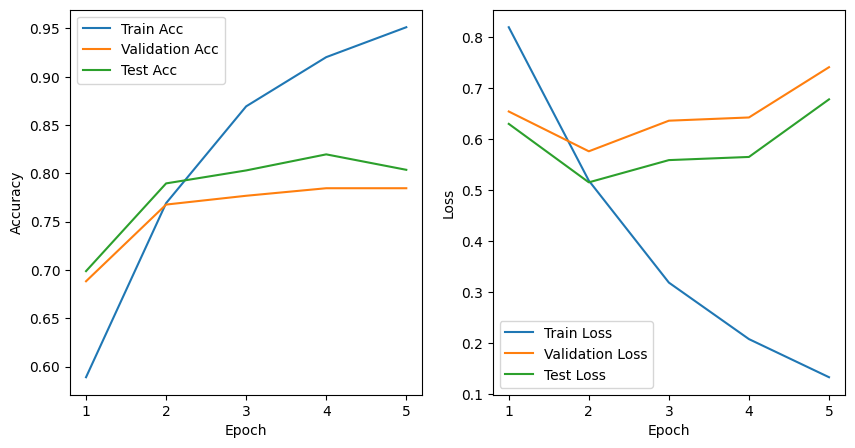

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", ft_o9l_history["train_acc"]),
            ("Validation Acc", ft_o9l_history["valid_acc"]),
            ("Test Acc", ft_o9l_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", ft_o9l_history["train_loss"]),
            ("Validation Loss", ft_o9l_history["valid_loss"]),
            ("Test Loss", ft_o9l_history["test_loss"]),
        ]
    }
)

Generate data:   0%|          | 0/49 [00:00<?, ?it/s]

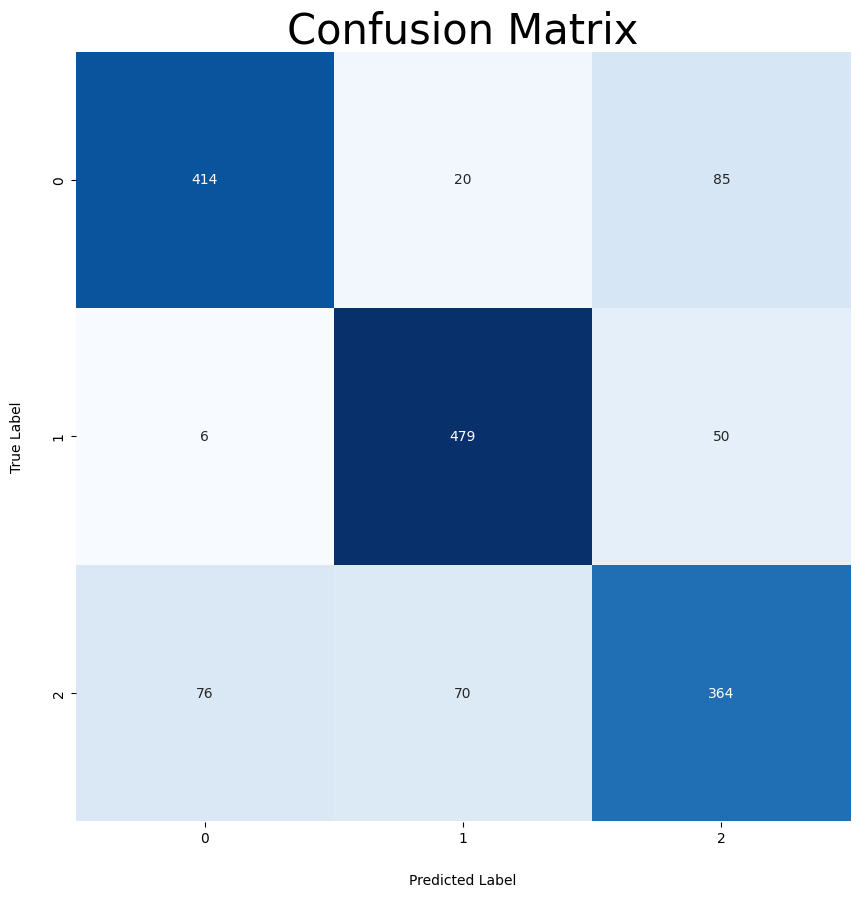

In [ ]:
ft_o9l_report = generate_confusion_matrix(
    model=model,
    dataset=test_tokenized,
)

In [ ]:
print(f"Recall:    {ft_o9l_report['recall']:.3f}")
print(f"F1:        {ft_o9l_report['f1']:.3f}")
print(f"Precision: {ft_o9l_report['precision']:.3f}")
print(ft_o9l_report['report'])

Recall:    0.802
F1:        0.802
Precision: 0.802
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       519
           1       0.84      0.90      0.87       535
           2       0.73      0.71      0.72       510

    accuracy                           0.80      1564
   macro avg       0.80      0.80      0.80      1564
weighted avg       0.80      0.80      0.80      1564



In [ ]:
del model

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

10744

# Fine-Tune with pruned attention heads

In [ ]:
def prune_half_attention_heads(model, seed=42):
  num_layers = model.config.num_hidden_layers
  num_heads = model.config.num_attention_heads
  np.random.seed(42)

  for layer in range(num_layers):
    heads_to_prune = np.random.choice(num_heads, size=num_heads//2, replace=False)
    model.prune_heads({layer: heads_to_prune})

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
prune_half_attention_heads(model)

In [ ]:
report_learnable_param(model)

All       Parameters: 148674051 
Learnable Parameters: 148674051  (100.00%)
Frozen    Parameters: 0          (0.00%)


In [ ]:
ft_pruned_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    train_set=train_tokenized,
    valid_set=valid_tokenized,
    test_set=test_tokenized,
    lr=LEARNING_RATE,
)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

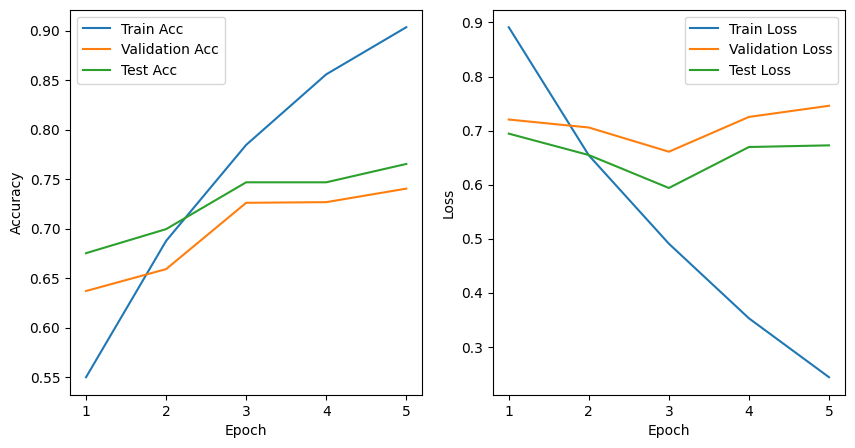

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", ft_pruned_history["train_acc"]),
            ("Validation Acc", ft_pruned_history["valid_acc"]),
            ("Test Acc", ft_pruned_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", ft_pruned_history["train_loss"]),
            ("Validation Loss", ft_pruned_history["valid_loss"]),
            ("Test Loss", ft_pruned_history["test_loss"]),
        ]
    }
)

Generate data:   0%|          | 0/49 [00:00<?, ?it/s]

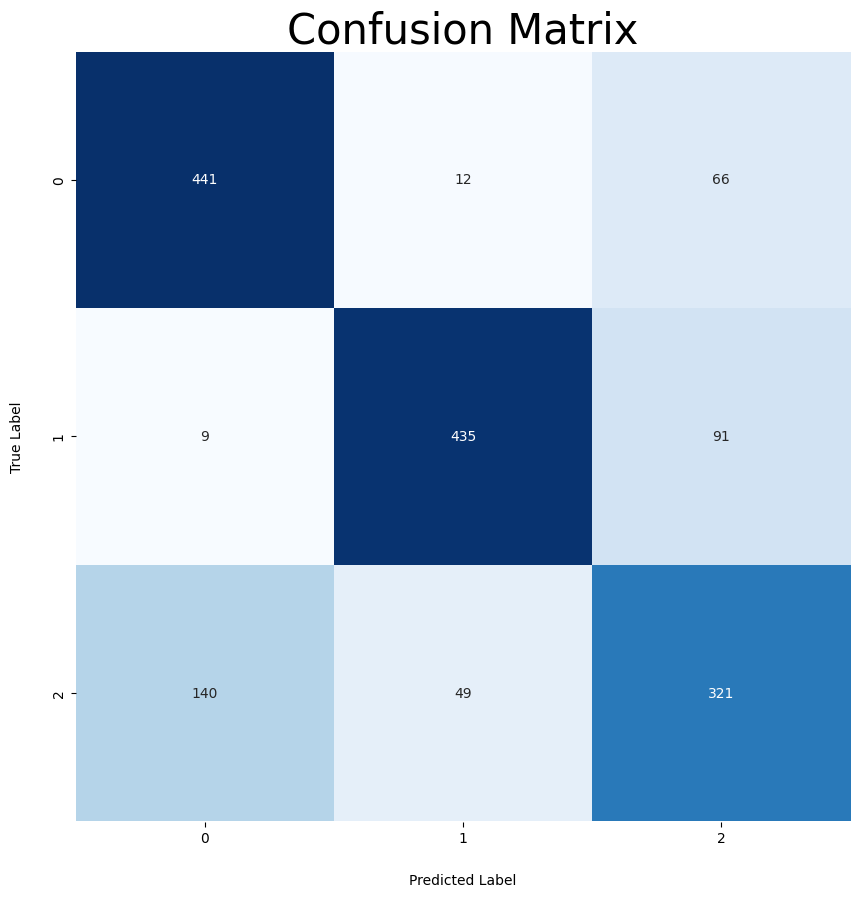

In [ ]:
ft_pruned_report = generate_confusion_matrix(
    model=model,
    dataset=test_tokenized,
)

In [ ]:
print(f"Recall:    {ft_pruned_report['recall']:.3f}")
print(f"F1:        {ft_pruned_report['f1']:.3f}")
print(f"Precision: {ft_pruned_report['precision']:.3f}")
print(ft_pruned_report['report'])

Recall:    0.764
F1:        0.763
Precision: 0.765
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       519
           1       0.88      0.81      0.84       535
           2       0.67      0.63      0.65       510

    accuracy                           0.77      1564
   macro avg       0.77      0.76      0.76      1564
weighted avg       0.77      0.77      0.76      1564



In [ ]:
del model, ft_pruned_report

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

10782

# Comparing Methods

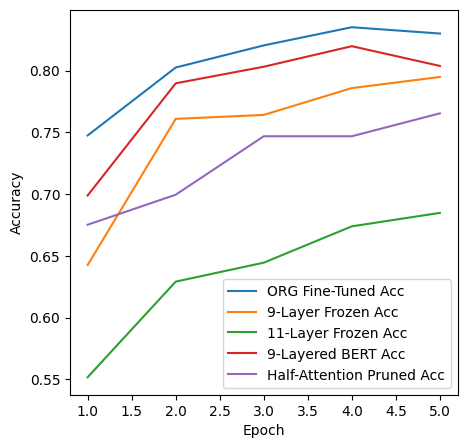

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("ORG Fine-Tuned Acc", nft_history["test_acc"]),
            ("9-Layer Frozen Acc", ft_9lf_history["test_acc"]),
            ("11-Layer Frozen Acc", ft_11lf_history["test_acc"]),
            ("9-Layered BERT Acc", ft_o9l_history["test_acc"]),
            ("Half-Attention Pruned Acc", ft_pruned_history["test_acc"]),
        ]
    }
)

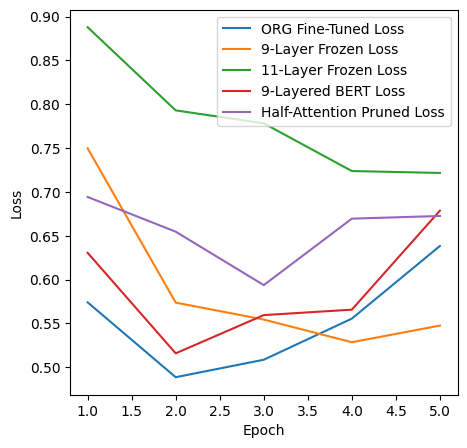

In [ ]:
trend_plot_helper(
    {
        "Loss - Epoch": [
            ("ORG Fine-Tuned Loss", nft_history["test_loss"]),
            ("9-Layer Frozen Loss", ft_9lf_history["test_loss"]),
            ("11-Layer Frozen Loss", ft_11lf_history["test_loss"]),
            ("9-Layered BERT Loss", ft_o9l_history["test_loss"]),
            ("Half-Attention Pruned Loss", ft_pruned_history["test_loss"]),
        ]
    }
)

|Method|Accuracy|Precision|Recall|F1-Score|
|-----|---|---|---|---|
|Ordinary FT|0.83|0.830|0.829|0.829|
|9-B-Layer Frozed FT|0.79|0.796|0.793|0.792|
|11-B-Layer Frozen FT|0.68|0.682|0.682|0.70|
|First BERT's 9-Layers FT|0.80|0.802|0.802|0.802|
|Half Attention heads pruned FT|0.77|0.765|0.764|0.763|
